In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy
import sys
from matplotlib.path import Path
import emcee
import corner
import time
from multiprocessing import Pool

In [37]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Step 1. Analyse the DR2 data

In [2]:
def read_fits (name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data

In [4]:
dr2_data = np.genfromtxt('/scratch/GDR2/47Tuc.dat', missing_values= "", filling_values= np.nan)
dr2_data = dr2_data.T
#dr2_data = read_fits('/home/pol/PhD_DATA/GDR2/47Tuc.fits')

In [5]:
# We need to remove the stars that don't have PM data.
print(dr2_data.shape)
bad_indeces = np.where(np.isnan(dr2_data[4]))
dr2_data = np.delete(dr2_data, bad_indeces, 1)
print(dr2_data.shape)

(14, 407331)
(14, 336424)


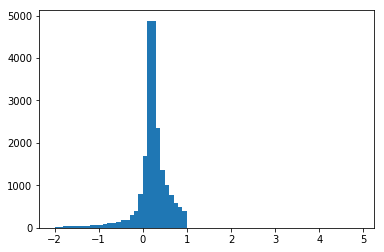

In [10]:
plt.hist(dr2_data[4], bins = np.arange(-2,5,0.1))
plt.show()

In [10]:
print(dr2_data.shape)

(14, 21540)


Let's remove stars that are within 1kpc from us first and see how it looks. It will remove some contamination that we might have.

In [6]:
bad_indeces = np.where(dr2_data[4] > 1)
dr2_data = np.delete(dr2_data, bad_indeces, 1)

In [7]:
print(dr2_data.shape)

(14, 303546)


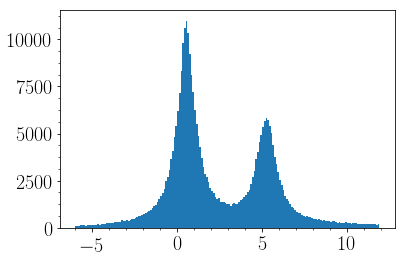

In [43]:
plt.hist(dr2_data[6], bins = np.arange(-6,12,0.1))
plt.minorticks_on()
plt.show()

In [8]:
bad_indeces = np.where(dr2_data[6] > 12)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
bad_indeces = np.where(dr2_data[6] < -6)
dr2_data = np.delete(dr2_data, bad_indeces, 1)

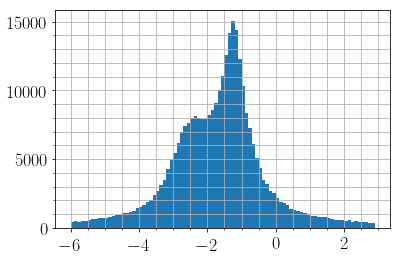

In [59]:
plt.hist(dr2_data[8], bins = np.arange(-6,3,0.1))
plt.minorticks_on()
plt.grid(which = 'both')
plt.show()

In [9]:
bad_indeces = np.where(dr2_data[8] > 4)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
bad_indeces = np.where(dr2_data[8] < -9)
dr2_data = np.delete(dr2_data, bad_indeces, 1)

In [10]:
print(dr2_data.shape)

(14, 290404)


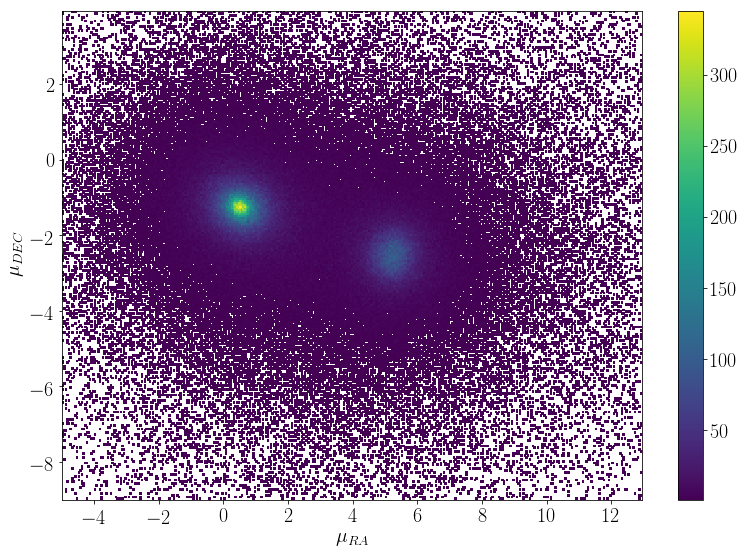

In [42]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
plt.figure(1, figsize=(13,9))
plt.hist2d(dr2_data[6], dr2_data[8], bins = [np.arange(-5,13,0.05), np.arange(-9,4,0.05)], cmin = 1)
plt.xlabel('$\mu _{RA}$')
plt.ylabel('$\mu _{DEC}$')
plt.colorbar()
plt.show()

# Intermediate step. Testing with double gaussian fitting

First, we create a model with two gaussians in one dimension

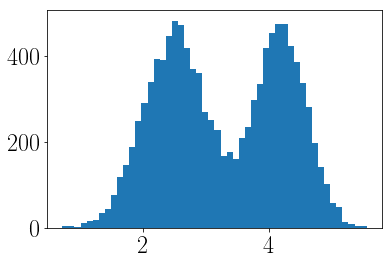

In [36]:
mean1 = 4.2
std1int = 0.4
std1obs = 0.1
size1 = 5000
obs_errors1 = np.random.normal(loc = 0.0, scale = std1obs, size = size1)

mean2 = 2.5
std2int = 0.5
std2obs = 0.1
size2 = 6000
obs_errors2 = np.random.normal(loc = 0.0, scale = std2obs, size = size2)

gaussian1 = np.random.normal(loc = mean1, scale = std1int, size = size1) + obs_errors1
gaussian2 = np.random.normal(loc = mean2, scale = std2int, size = size2) + obs_errors2
gaussians = np.concatenate((gaussian1, gaussian2))
obs_errors = np.concatenate((obs_errors1, obs_errors2))
#print gaussians.size
plt.hist(gaussians, bins = 50)
plt.show()

In [37]:
def lnlike(theta, x, xerr):
    p, mu1, sigma1, mu2, sigma2 = theta
    likelihood = p * (1.0/np.sqrt(2.0*np.pi*(sigma1**2 + xerr**2))) * np.exp((x-mu1)**2/(-2.0*(sigma1**2 + xerr**2))) \
    + (1.0-p) * (1.0/np.sqrt(2.0*np.pi*(sigma2**2 + xerr**2))) * np.exp((x-mu2)**2/(-2.0*(sigma2**2 + xerr**2)))
    return np.sum(np.log(likelihood))

In [38]:
def lnprior(theta):
    p, mu1, sigma1, mu2, sigma2 = theta
    if 0 < p < 1 and 3 < mu1 < 5 and 0 < sigma1 < 2 and 1 < mu2 < 3 and 0 < sigma2 < 2:
        return 0.0
    return -np.inf

In [39]:
def lnprob(theta, x, xerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, xerr)

In [40]:
ndim, nwalkers = 5, 100
init_pos = [[0.5, 4.0, 1.0, 2.0, 1.0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(gaussians, obs_errors))
number_iterations = 1000
sampler.run_mcmc(init_pos, number_iterations)

(array([[0.45462102, 4.20095918, 0.38784966, 2.51838081, 0.50372704],
        [0.45744808, 4.18480221, 0.39860589, 2.50484748, 0.49667232],
        [0.45065441, 4.18354713, 0.38910415, 2.50629869, 0.50177535],
        [0.45704223, 4.20762945, 0.39263391, 2.5087007 , 0.4863183 ],
        [0.44340591, 4.20728783, 0.38439599, 2.51330671, 0.50275745],
        [0.45202814, 4.20137343, 0.38338247, 2.51818244, 0.50203139],
        [0.45890009, 4.20374675, 0.38657343, 2.51783276, 0.49062224],
        [0.45177934, 4.19426269, 0.38686301, 2.50162464, 0.49757518],
        [0.44840472, 4.19541327, 0.3863182 , 2.51406254, 0.5007431 ],
        [0.4516837 , 4.19562605, 0.39234499, 2.50621666, 0.49500463],
        [0.45097932, 4.18969254, 0.39905294, 2.50531675, 0.49837978],
        [0.45171619, 4.20289858, 0.38547567, 2.52397424, 0.49570939],
        [0.45142951, 4.19674186, 0.37975338, 2.53440033, 0.49855369],
        [0.45779608, 4.19692263, 0.39392552, 2.50099139, 0.48386094],
        [0.45843986,

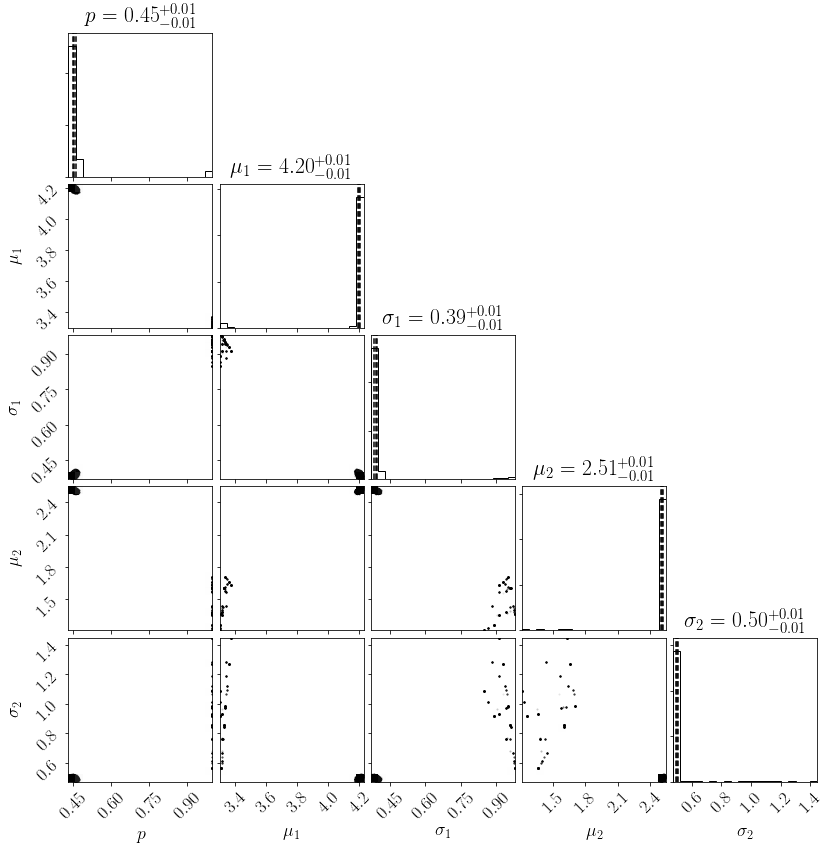

In [44]:
samples = sampler.chain[:, 700:, :].reshape((-1, ndim))
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["$p$", "$\mu_1$", "$\sigma_1$", "$\mu_2$", "$\sigma_2$"], quantiles = [0.16, 0.50, 0.84], show_titles=True)
fig.savefig("/home/pol/Documents/PhD/CMD_SMASH/Plots/test_emcee_double_gaussian_fitting.png")

# Step 2. Do some real fitting to the PM RA

In [13]:
def lnlike_2gaus(theta, x, xerr):
    p, mu1, sigma1, mu2, sigma2 = theta
    likelihood = p * (1.0/np.sqrt(2.0*np.pi*(sigma1**2 + xerr**2))) * np.exp((x-mu1)**2/(-2.0*(sigma1**2 + xerr**2))) \
    + (1.0-p) * (1.0/np.sqrt(2.0*np.pi*(sigma2**2 + xerr**2))) * np.exp((x-mu2)**2/(-2.0*(sigma2**2 + xerr**2)))
    return np.sum(np.log(likelihood))

In [14]:
def lnprior_2gaus(theta):
    p, mu1, sigma1, mu2, sigma2 = theta
    if 0 < p < 1 and -2 < mu1 < 3 and 0 < sigma1 < 2 and 3 < mu2 < 7 and 0 < sigma2 < 2.5:
        return 0.0
    return -np.inf

In [17]:
def lnlike_1gaus(theta, x, xerr):
    mu, sigma, background = theta
    likelihood = (1.0/np.sqrt(2.0*np.pi*(sigma**2 + xerr**2))) * np.exp((x-mu)**2/(-2.0*(sigma**2 + xerr**2))) + background
    return np.sum(np.log(likelihood))

In [18]:
def lnprior_1gaus(theta):
    mu, sigma, background = theta
    if 2 < mu < 8 and 0 < sigma < 3 and 0 < background < 150:
        return 0.0
    return -np.inf

In [31]:
def lnlike_1cauchy(theta, x, xerr):
    x0, gamma = theta
    likelihood = 1/(np.pi*gamma*(1 + ((x-x0)/gamma)**2))
    return np.sum(np.log(likelihood))

In [30]:
def lnprior_1cauchy(theta):
    x0, gamma = theta
    if 2 < x0 < 8 and 0 < gamma < 3:
        return 0.0
    return -np.inf

In [33]:
def lnlike_2cauchy(theta, x, xerr):
    p, x0_1, gamma_1, x0_2, gamma_2 = theta
    likelihood = p*(1/(np.pi*gamma_1*(1 + ((x-x0_1)/gamma_1)**2))) + (1-p)*(1/(np.pi*gamma_2*(1 + ((x-x0_2)/gamma_2)**2)))
    return np.sum(np.log(likelihood))

In [34]:
def lnprior_2cauchy(theta):
    p, x0_1, gamma_1, x0_2, gamma_2 = theta
    if 0 < p < 1 and -1 < x0_1 < 3 and 0 < gamma_1 < 2 and 2 < x0_2 < 8 and 0 < gamma_2 < 2:
        return 0.0
    return -np.inf

In [35]:
def lnprob(theta, x, xerr):
    lp = lnprior_2cauchy(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_2cauchy(theta, x, xerr)

In [32]:
# For 1 component
ndim, nwalkers = 2, 100
init_pos = [[5.0, 1.5] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [36]:
# For 2 components
ndim, nwalkers = 5, 100
init_pos = [[0.5, 1.0, 1.0, 5.0, 1.0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [39]:
time_start = time.time()
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dr2_data[6], dr2_data[7]), pool=pool)
    number_iterations = 2000
    sampler.run_mcmc(init_pos, number_iterations)
time_end = time.time()
print(time_end-time_start)

985.399418592453


In [41]:
samples = sampler.chain[:, 300:, :].reshape((-1, ndim))
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["p", "$x0_1$", "$\gamma_1$", "$x0_2$", "$\gamma_2$"], quantiles = [0.16, 0.50, 0.84], show_titles=True)
fig.savefig("/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/47tuc_pmra_double_cauchy_fitting.png")

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4 have no dynamic range. Please provide a `range` argument.

In [50]:
p_fit, x0_1_fit, gamma_1_fit, x0_2_fit, gamma_2_fit = np.percentile(samples, 50, axis=0)
print(p_fit, x0_1_fit, gamma_1_fit, x0_2_fit, gamma_2_fit)

0.6045532565245508 0.5483222866401896 0.6228174345845806 5.255997252219416 0.7936053672187448


In [25]:
def double_gaussian(x, mean1, sigma1, mean2, sigma2, amplitude = 0.5):
    return amplitude * ( np.exp(-0.5 * (x-mean1)**2 / (sigma1**2)) / np.sqrt(2.0 * np.pi * sigma1**2) + \
    np.exp(-0.5 * (x-mean2)**2 / (sigma2**2)) / np.sqrt(2.0 * np.pi * sigma2**2) )

In [56]:
def one_gaussian(x, mean, sigma, amplitude = 1.0):
    return (amplitude * np.exp(-0.5 * (x-mean)**2 / (sigma**2))) / (np.sqrt(2.0 * np.pi * sigma**2))

In [11]:
def one_cauchy(x, x0, gamma):
    return 1/(np.pi*gamma*(1 + ((x-x0)/gamma)**2))

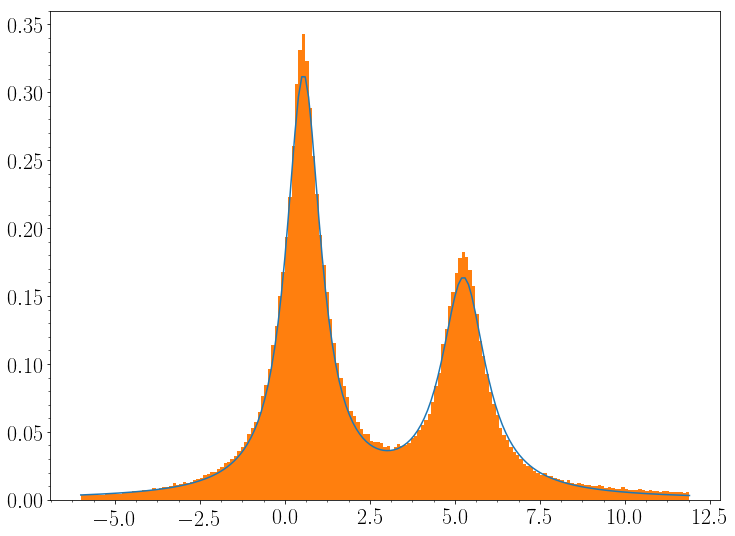

In [51]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,9))

x_values = np.arange(-6,12, 0.1)
fit_values = p_fit * one_cauchy(x_values, x0_1_fit, gamma_1_fit) + (1.0-p_fit) * one_cauchy(x_values, x0_2_fit, gamma_2_fit)

plt.plot(x_values, fit_values)
plt.hist(dr2_data[6], bins = np.arange(-6,12,0.1), density = True)
plt.minorticks_on()
plt.show()

Right, doesn't work. Let's see if we can imporve the determination of the proper motion of the cluster by doing more cuts on the data set based on colours and magnitudes.

# CMD cutting

87.0


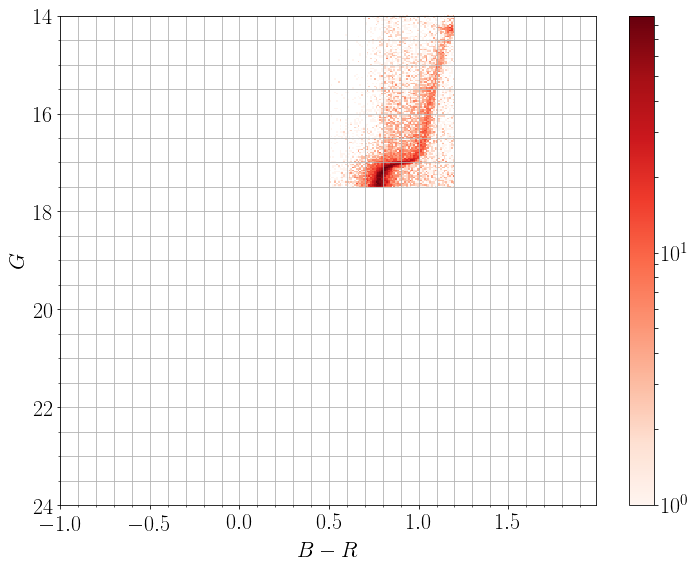

In [44]:
xbinsize = 0.01
ybinsize = 0.03
xbins = np.arange( start = -1, stop = 2, step = xbinsize)
ybins = np.arange( start = 14, stop = 24, step = ybinsize)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':22})
plt.figure(1, figsize=(12,9))

hist2d_data = np.histogram2d(dr2_data[12], dr2_data[11], bins = [xbins,ybins])
print(np.max(hist2d_data[0]))
plt.hist2d(dr2_data[12], dr2_data[11], bins = [xbins,ybins], cmap = 'Reds', cmin = 1, norm = matplotlib.colors.LogNorm())
plt.colorbar()

# Anotations for 47Tuc
#plt.annotate('NGC104 MS\n+ SMC RC', xy = (0.8,19.8), xycoords = 'data', xytext = (-0.5,17), arrowprops = dict(arrowstyle='->'))

# Annotations for NGC362
#plt.annotate('NGC362 MS\n+ SMC RGB', xy = (0.75,21.4), xycoords = 'data', xytext = (1.1,21.2), arrowprops = dict(arrowstyle='->'))

plt.gca().invert_yaxis()
plt.xlabel('$B-R$')
plt.ylabel('$G$')
plt.minorticks_on()
plt.grid(which='both')
#plt.title('Field 4')
plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/CMD_47Tuc_DR2_before_cleaning.pdf', bbox_inches='tight')
plt.show()

Well, shit, not much we can do here. Cuts in magnitude won't be very useful, so we can make a soft cut in colour.

In [8]:
bad_indeces = np.where(dr2_data[12] < 0.5)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
#bad_indeces = np.where(dr2_data[12] > 1.6)
#dr2_data = np.delete(dr2_data, bad_indeces, 1)
print(dr2_data.shape)

(14, 275034)


Alright, everything's pretty bad. Let's just try to see if we can get the PM parameters only for the cluster.

In [9]:
bad_indeces = np.where(dr2_data[11] > 17.5)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
bad_indeces = np.where(dr2_data[12] > 1.2)
dr2_data = np.delete(dr2_data, bad_indeces, 1)
print(dr2_data.shape)

(14, 21540)


OK, so take home message is: do only one component and change distribution to Cauchy.

Right, no. 2 components.

# Supreme 2D fitting

In [47]:
def lnlike_2D_2cauchy(theta, x, y):
    p, x0_1, y0_1, gamma_1, x0_2, y0_2, gamma_2 = theta
    likelihood = (p*gamma_1)/(((x-x0_1)**2 + (y-y0_1)**2 + gamma_1**2)**1.5) + ((1-p)*gamma_2)/(((x-x0_2)**2 + (y-y0_2)**2 + gamma_2**2)**1.5)
    return np.sum(np.log(likelihood))

In [48]:
def lnprior_2D_2cauchy(theta):
    p, x0_1, y0_1, gamma_1, x0_2, y0_2, gamma_2 = theta
    if 0 < p < 1 and -1 < x0_1 < 3 and -2 < y0_1 < -0.5 and 0 < gamma_1 < 2 and 2 < x0_2 < 8 and -3 < y0_2 < -2 and 0 < gamma_2 < 2:
        return 0.0
    return -np.inf

In [49]:
def lnprob(theta, x, y):
    lp = lnprior_2D_2cauchy(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_2D_2cauchy(theta, x, y)

In [50]:
# For 2 dimensions and 2 components
ndim, nwalkers = 7, 100
init_pos = [[0.5, 0.5, -1.0, 1.0, 5.0, -2.5, 1.0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [51]:
time_start = time.time()

number_mcmc = 200
number_iterations = 2000
params = []
for i in range(number_mcmc):
    random_pms = []
    for pm, covariance in zip(proper_motions.T, covar):
        random_pm = np.random.multivariate_normal(pm, covariance)
        random_pms.append(random_pm)
    random_pms = np.array(random_pms).T
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(random_pms[0], random_pms[1]), pool=pool)
        sampler.run_mcmc(init_pos, number_iterations)
    samples = sampler.chain[:, 400:, :].reshape((-1, ndim))
    params.append(np.percentile(samples, 50, axis=0))
    print(i)

time_end = time.time()
print( (time_end-time_start) )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
547020.045707941


In [52]:
params_array = np.array(params)
print(params_array.shape)

(200, 7)


In [55]:
np.savetxt('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/47Tuc_doublecauchy_200fits_results.txt', params_array, header='p x0_1 y0_1 gamma1 x0_2 y0_2 gamma2')

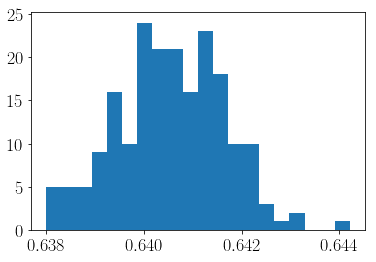

In [59]:
plt.hist(params_array[:,3], bins=20)
plt.show()

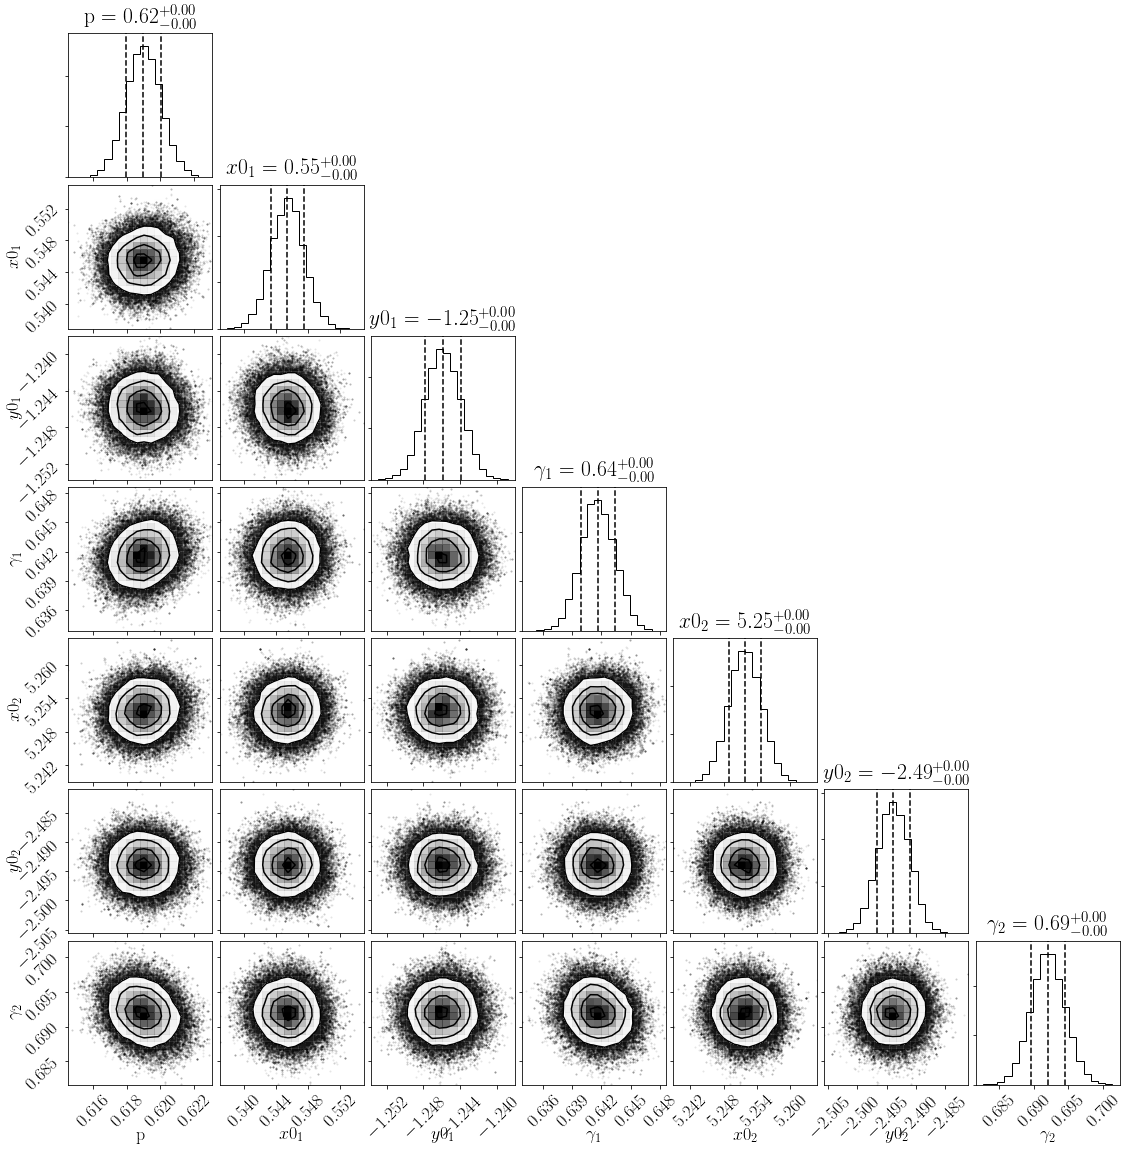

In [53]:
#samples = sampler.chain[:, 400:, :].reshape((-1, ndim))
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["p", "$x0_1$", "$y0_1$", "$\gamma_1$", "$x0_2$", "$y0_2$", "$\gamma_2$"], quantiles = [0.16, 0.50, 0.84], show_titles=True)
fig.savefig("/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/47tuc_pm_double_cauchy_fitting.png")

In [30]:
proper_motions = np.stack((dr2_data[6], dr2_data[8]))
proper_motions_errors = np.stack((dr2_data[7], dr2_data[9]))
cov1=np.zeros(shape=(len(dr2_data[6]),2,2))
cov1[:,0,0]=proper_motions_errors[0]
cov1[:,1,1]=proper_motions_errors[1]
cov2=np.ones(shape=(len(dr2_data[6]),2,2))
cov2[:,0,1]=dr2_data[10]
cov2[:,1,0]=dr2_data[10]

covar=np.matmul(cov1,(np.matmul(cov2,cov1)))
print(covar.shape)

(290404, 2, 2)


In [31]:
time_start = time.time()

random_pms = []
for pm, covariance in zip(proper_motions.T, covar):
    random_pm = np.random.multivariate_normal(pm, covariance)
    random_pms.append(random_pm)

time_end = time.time()
print( (time_end-time_start) )

21.467406511306763


In [8]:
def cauchy_2D(x, y, theta):
    p, x0_1, y0_1, gamma_1, x0_2, y0_2, gamma_2 = theta
    return (p*gamma_1)/(((x-x0_1)**2 + (y-y0_1)**2 + gamma_1**2)**1.5) + ((1-p)*gamma_2)/(((x-x0_2)**2 + (y-y0_2)**2 + gamma_2**2)**1.5)

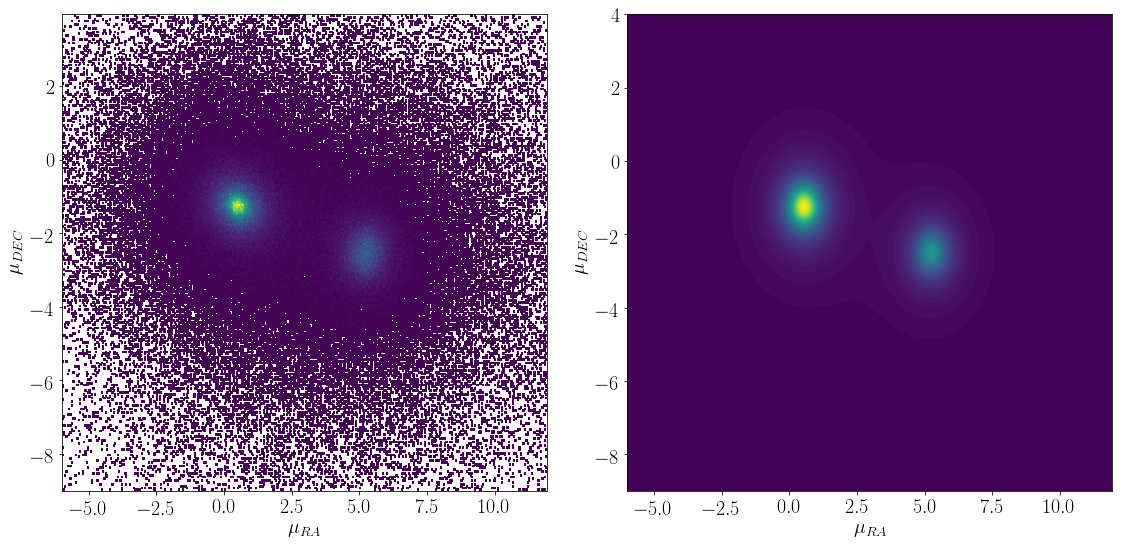

In [36]:
theta = np.mean(fit_data[:,0]), np.mean(fit_data[:,1]), np.mean(fit_data[:,2]), np.mean(fit_data[:,3]), np.mean(fit_data[:,4]), np.mean(fit_data[:,5]), np.mean(fit_data[:,6])
x_values, y_values = np.arange(-6, 12, 0.05), np.linspace(-9,4,360)
x_grid, y_grid = np.meshgrid(x_values, y_values)
z_values = cauchy_2D(x_grid, y_grid, theta)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
#plt.rcParams.update({'lines.linewidth':1.5})
plt.figure(1, figsize=(16,8))
plt.subplot(1, 2, 1)
plt.hist2d(dr2_data[6], dr2_data[8], bins = [np.arange(-6,12,0.05), np.arange(-9,4,0.05)], cmin = 1)
#plt.colorbar()
plt.xlabel('$\mu _{RA}$')
plt.ylabel('$\mu _{DEC}$')
plt.subplot(1, 2, 2)
plt.contourf(x_values, y_values, z_values, levels = 80)
plt.xlabel('$\mu _{RA}$')
plt.ylabel('$\mu _{DEC}$')
plt.tight_layout()
plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/47tuc_pm_2dcauchy_fitting_contours.pdf')
plt.show()

In [59]:
def cauchy_sampler(params, p_value):
    x_0, gamma = params
    return (x_0 + gamma * np.tan(np.pi*(p_value - 0.5)))

(0.5468150008908499, 0.6405528497403821)
0.5468150008908499 0.6405528497403821


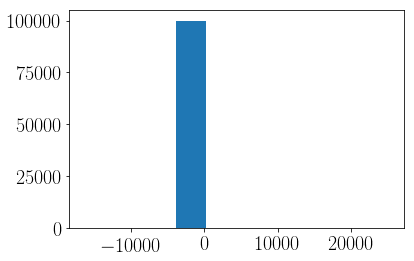

In [58]:
sample_number = 1e5

# We sample from 1 distribution (SMC).
uniform_values = np.random.random(int(sample_number))
x_params = np.mean(fit_data[:,1]), np.mean(fit_data[:,3])
x_values_smc = cauchy_sampler(x_params, uniform_values)
plt.hist(x_values_smc)
plt.show()

We now get the final parameters for the fit with the uncertainties.

In [2]:
fit_data = np.loadtxt('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/47Tuc_doublecauchy_200fits_results.txt')
print(np.mean(fit_data[:,0]), np.std(fit_data[:,0]))
print(np.mean(fit_data[:,1]), np.std(fit_data[:,1]))
print(np.mean(fit_data[:,2]), np.std(fit_data[:,2]))
print(np.mean(fit_data[:,3]), np.std(fit_data[:,3]))
print(np.mean(fit_data[:,4]), np.std(fit_data[:,4]))
print(np.mean(fit_data[:,5]), np.std(fit_data[:,5]))
print(np.mean(fit_data[:,6]), np.std(fit_data[:,6]))

0.6187749715710846 0.0003568299517595589
0.5468150008908499 0.0018535519216949603
-1.2453285442345834 0.0013857059528789074
0.6405528497403821 0.0011028564488831665
5.252357921133512 0.0019858923609083648
-2.4938381471975855 0.0016393449965333737
0.6917564023118037 0.0012804183478053914


In [3]:
p_mean, p_std = np.mean(fit_data[:,0]), np.std(fit_data[:,0])
x01_mean, x01_std = np.mean(fit_data[:,1]), np.std(fit_data[:,1])
y01_mean, y01_std = np.mean(fit_data[:,2]), np.std(fit_data[:,2])
gamma1_mean, gamma1_std = np.mean(fit_data[:,3]), np.std(fit_data[:,3])
x02_mean, x02_std = np.mean(fit_data[:,4]), np.std(fit_data[:,4])
y02_mean, y02_std = np.mean(fit_data[:,5]), np.std(fit_data[:,5])
gamma2_mean, gamma2_std = np.mean(fit_data[:,6]), np.std(fit_data[:,6])

# Membership determination

In [76]:
def membership_probability(func_params, cluster_radius, position_data, pm_data_ra, pm_data_dec):
    ra0, dec0, gamma = func_params
    pm_prob = 1.0/(1.0 + ((pm_data_ra-ra0)/gamma)**2 + ((pm_data_dec-dec0)/gamma)**2)**1.5
    position_prob = np.exp((-1.0*position_data**2)/(2.0*cluster_radius**2))
    prob = pm_prob * position_prob
    return prob

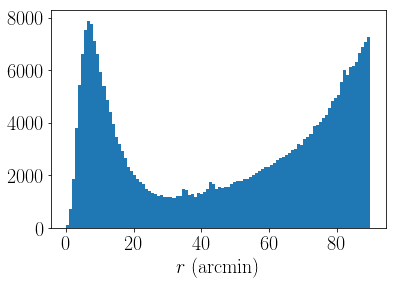

In [46]:
cluster_centre = SkyCoord.from_name('NGC104')
stars_coordinates = SkyCoord(dr2_data[0], dr2_data[2], unit = 'deg')
angular_separation = cluster_centre.separation(stars_coordinates).arcmin
plt.hist(angular_separation, bins = 100)
plt.xlabel('$r$ (arcmin)')
plt.show()

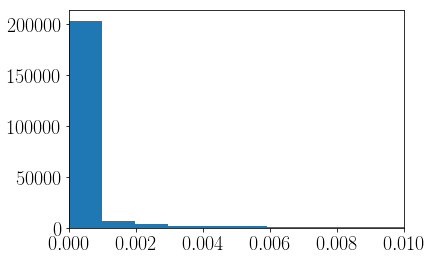

In [103]:
pm_fit_params = np.mean(fit_data[:,4]), np.mean(fit_data[:,5]), np.mean(fit_data[:,6])
cluster_radius = 15.0 #arcmin
membership_probabilities = membership_probability(pm_fit_params, cluster_radius, angular_separation, dr2_data[6], dr2_data[8])
plt.hist(membership_probabilities, bins=1000)
plt.xlim(0,0.01)
plt.show()

In [108]:
pm_classification = np.stack((dr2_data[6], dr2_data[8], membership_probabilities))
probability_threshold = 0.004
non_cluster_members_pm = pm_classification[0][pm_classification[2] < probability_threshold], pm_classification[1][pm_classification[2] < probability_threshold]
cluster_members_pm = pm_classification[0][pm_classification[2] > probability_threshold], pm_classification[1][pm_classification[2] > probability_threshold]

cluster_mask = np.where(membership_probabilities > probability_threshold)

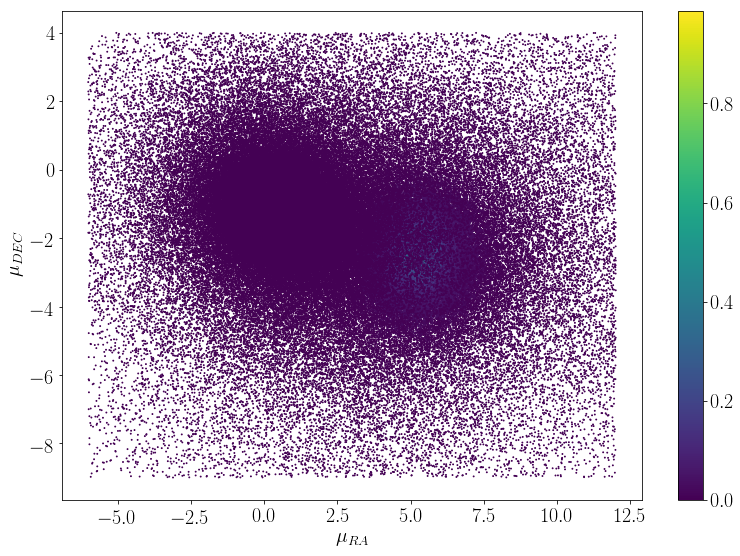

In [112]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':20})
plt.figure(1, figsize=(13,9))
plt.scatter(dr2_data[6], dr2_data[8], c = membership_probabilities, s=0.8)
#plt.scatter(non_cluster_members_pm[0], non_cluster_members_pm[1], s=0.8)
plt.xlabel('$\mu _{RA}$')
plt.ylabel('$\mu _{DEC}$')
plt.colorbar()
plt.show()

In [110]:
print(len(cluster_members_pm[0]))

96867


In [120]:
data_mask = np.ma.masked_less(membership_probabilities, probability_threshold).mask
data_mask = np.broadcast_to(data_mask, (14, len(membership_probabilities)))

In [136]:
non_cluster_mask = np.where(membership_probabilities < probability_threshold)
dr2_data_cluster = np.delete(dr2_data, non_cluster_mask, axis = 1)

In [137]:
dr2_data_cluster.shape

(14, 96867)

In [138]:
np.savetxt('/scratch/GDR2/47Tuc_members.dat', dr2_data_cluster.T, header='ra                   ra_error               dec                  dec_error              parallax                parallax_error         pmra                   pmra_error             pmdec                  pmdec_error            pmra_pmdec_corr   phot_g_mean_mag   bp_rp        a_g_val')

# Fitting check

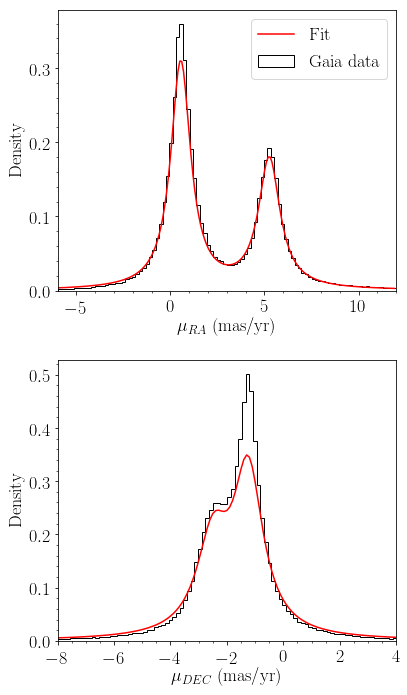

In [13]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})
plt.figure(figsize = (6,10))

x_values = np.arange(-9, 12, 0.1)
fit_values = p_mean * one_cauchy(x_values, x01_mean, gamma1_mean) + (1.0-p_mean) * one_cauchy(x_values, x02_mean, gamma2_mean)

plt.subplot(211)
plt.hist(dr2_data[6], bins = 100, density = True, facecolor = 'None', histtype='step', edgecolor = 'k')
plt.plot(x_values, fit_values, color='red')
plt.xlabel('$\mu _{RA}$ (mas/yr)')
plt.ylabel('Density')
plt.xlim(-6,12)
plt.minorticks_on()
plt.legend(('Fit', 'Gaia data'), loc='upper right')

fit_values = p_mean * one_cauchy(x_values, y01_mean, gamma1_mean) + (1.0-p_mean) * one_cauchy(x_values, y02_mean, gamma2_mean)

plt.subplot(212)
plt.hist(dr2_data[8], bins = 100, density = True, facecolor = 'None', histtype='step', edgecolor = 'k')
plt.plot(x_values, fit_values, color='red')
plt.xlabel('$\mu _{DEC}$ (mas/yr)')
plt.ylabel('Density')
plt.xlim(-8,4)
plt.minorticks_on()

plt.tight_layout()
plt.savefig('/user/HS128/pm00518/Documents/PhD/CMD_SMASH/Plots/47Tuc_DoubleCauchyFit_histogram.pdf')
plt.show()

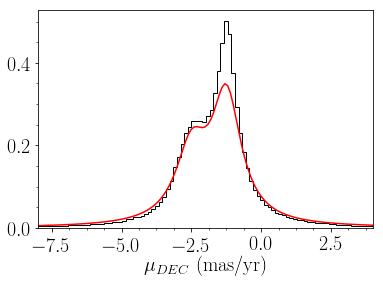

In [35]:
fit_values = p_mean * one_cauchy(x_values, y01_mean, gamma1_mean) + (1.0-p_mean) * one_cauchy(x_values, y02_mean, gamma2_mean)

plt.hist(dr2_data[8], bins = 100, density = True, facecolor = 'None', histtype='step', edgecolor = 'k')
plt.plot(x_values, fit_values, color='red')
plt.xlabel('$\mu _{DEC}$ (mas/yr)')
plt.xlim(-8,4)
plt.minorticks_on()
plt.show()